In [1]:
from bs4 import BeautifulSoup
from collections import defaultdict
from ortools.linear_solver.pywraplp import Solver
from scipy.special import expit
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import requests


In [2]:
# Simulation parameters
MONTE_CARLO_ROUNDS = 10000

# Plot display parameters
ELO_SPACING = 20


In [3]:
# A description of result tiers and points for each tier (in a single GP leg)
tiers = ["winner", "runner-up", "semifinalist", "group runner-up", "group 3rd place", "group last"]
points = [13, 10, 7, 4, 2, 0]
max_points = max(points)

# A dict mapping tier to points received
tier_to_points = {tiers[i]: points[i] for i in range(len(tiers))}

# An array mapping index in leg standings to points received
place_to_points = [13, 10] + [7] * 2 + [4] * 4 + [2] * 4 + [0] * 4


In [4]:
name_to_rating = {
    "Ding Liren": 2799.0,
    "Levon Aronian": 2785,
    "Wesley So": 2778,
    "Shakhriyar Mamedyarov": 2771.2,
    "Anish Giri": 2772.8,
    "Richard Rapport": 2776.4,
    "Maxime Vachier-Lagrave": 2757.8,
    "Alexander Grischuk": 2742,
    "Leinier Dominguez": 2756,
    "Hikaru Nakamura": 2750,
    "Nikita Vitiugov": 2724.2,
    "Dmitry Andreikin": 2729.4,
    "Andrey Esipenko": 2723,
    "Vidit Gujrathi": 2722.6,
    "Pentala Harikrishna": 2705.2,
    "Yu Yangyi": 2710.4,
    "Daniil Dubov": 2711,
    "Vladimir Fedoseev": 2700.8,
    "Sam Shankland": 2709.2,
    "Radoslaw Wojtaszek": 2696.2,
    "Alexei Shirov": 2689.2,
    "Alexandr Predke": 2687.6,
    "Grigoriy Oparin": 2674.0,
    "Vincent Keymer": 2654.5,
    "Etienne Bacrot": 2637.8,
    "Amin Tabatabaei": 2632.4,
}
hikaru = "Hikaru Nakamura"


In [5]:
# Probabilities taken from https://chance.amstat.org/2020/09/chess/

prob_draw = lambda rwhite, rblack: expit(
    -1.627 + 0.0006955 * rwhite - 0.004668 * abs(rwhite - rblack)
)
prob_beats = lambda ra, rb: 1 / (1 + 10 ** ((rb - ra) / 400))
prob_win = lambda rwhite, rblack: prob_beats(rwhite, rblack) - prob_draw(rwhite, rblack) / 2


In [6]:
def sim_match(elo1, elo2):
    points = 0

    pdraw1 = prob_draw(elo1, elo2)
    pbeats1 = prob_beats(elo1, elo2)
    pwin1 = pbeats1 - pdraw1 / 2

    rand = random.random()
    if rand <= pwin1:
        points += 1
    elif rand > pwin1 + pdraw1:
        points -= 1

    pdraw2 = prob_draw(elo2, elo1)
    pbeats2 = prob_beats(elo2, elo1)
    pwin2 = pbeats2 - pdraw2 / 2

    rand = random.random()
    if rand <= pwin2:
        points -= 1
    elif rand > pwin2 + pdraw2:
        points += 1

    return points


def sim_group(inds, elos):
    n = len(inds)
    points = [0] * n
    for i in range(n):
        for j in range(i + 1, n):
            res = sim_match(elos[inds[i]], elos[inds[j]])
            points[i] += res
            points[j] -= res
    inds_rankings = list(sorted(range(n), key=lambda i: points[i], reverse=True))
    tiebreak = int(points[inds_rankings[0]] != points[inds_rankings[1]])
    while tiebreak == 0:
        ind0, ind1 = inds_rankings[0], inds_rankings[1]
        tiebreak = sim_match(elos[inds[ind0]], elos[inds[ind1]])
        if tiebreak < 0:
            inds_rankings[0], inds_rankings[1] = inds_rankings[1], inds_rankings[0]
    return [inds[i] for i in inds_rankings]


def sim_leg(elos, groups=None):
    n = len(elos)

    if groups is None:
        rand_inds = np.array(range(n))
        np.random.shuffle(rand_inds)
        groups = [list(g) for g in np.split(rand_inds, 4)]

    group_results = [sim_group(group, elos) for group in groups]

    rev_standings = []
    for group_place in range(3, 0, -1):
        for group_res in group_results:
            rev_standings.append(group_res[group_place])

    semis = [group_res[0] for group_res in group_results]
    semi1_res = sim_group(semis[:2], elos)
    semi2_res = sim_group(semis[2:], elos)
    rev_standings.append(semi1_res[1])
    rev_standings.append(semi2_res[1])
    finals = [semi1_res[0], semi2_res[0]]
    f_res = sim_group(finals, elos)
    rev_standings.append(f_res[1])
    rev_standings.append(f_res[0])

    leg_points = [0] * n
    for i, player in enumerate(reversed(rev_standings)):
        leg_points[player] = place_to_points[i]

    return leg_points


In [7]:
grand_prix_page = requests.get("https://www.chess.com/article/view/fide-grand-prix-2022")
grand_prix_soup = BeautifulSoup(grand_prix_page.text, "lxml")


In [8]:
# Leg 1

leg1_players_soup = grand_prix_soup.select(".standings_table")[2]
headers = []
for h in leg1_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg1_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg1_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg1_players_df = leg1_players_df.drop(["Fed"], axis=1)
leg1_players_df["Player"] = leg1_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg1_players_df["Rating"] = leg1_players_df["Player"].apply(lambda n: name_to_rating[n])

leg1_players_df["Leg 1 Points"] = pd.Series([4, 10, 2, 7, 7, 13, 4, 2, 3, 3, 2, 0, 4, 0, 0, 0])

leg1_players = leg1_players_df["Player"]

leg1_players_df


,Player,Rating,Leg 1 Points
0,Wesley So,2778.0,4
1,Levon Aronian,2785.0,10
2,Alexander Grischuk,2742.0,2
3,Richard Rapport,2776.4,7
4,Leinier Dominguez,2756.0,7
5,Hikaru Nakamura,2750.0,13
6,Andrey Esipenko,2723.0,4
7,Pentala Harikrishna,2705.2,2
8,Vidit Gujrathi,2722.6,3
9,Daniil Dubov,2711.0,3


In [9]:
# Leg 2 (simulated)

leg2_players_soup = grand_prix_soup.select(".standings_table")[5]
headers = []
for h in leg2_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg2_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg2_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg2_players_df["Player"] = leg2_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg2_players_df = leg2_players_df.drop(["Fed"], axis=1)
leg2_players_df["Rating"] = leg2_players_df["Player"].apply(lambda n: name_to_rating[n])

round2_elos = [float(elo) for elo in leg2_players_df["Rating"]]
leg2_players_df["Leg 2 Points"] = pd.Series([10, 7, 4, 0, 13, 7, 4, 0, 4, 0, 4, 2, 0, 2, 2, 2])

leg2_players = leg2_players_df["Player"]

leg2_players_df


,Player,Rating,Leg 2 Points
0,Dmitry Andreikin,2729.4,10
1,Anish Giri,2772.8,7
2,Shakhriyar Mamedyarov,2771.2,4
3,Alexander Grischuk,2742.0,0
4,Richard Rapport,2776.4,13
5,Maxime Vachier-Lagrave,2757.8,7
6,Nikita Vitiugov,2724.2,4
7,Pentala Harikrishna,2705.2,0
8,Vidit Gujrathi,2722.6,4
9,Yu Yangyi,2710.4,0


In [10]:
# Leg 3 (simulated)

leg3_players_soup = grand_prix_soup.select(".standings_table")[8]
headers = []
for h in leg3_players_soup.find("tr").find_all("td"):
    title = h.text
    headers.append(title)
leg3_players_df = pd.DataFrame(
    [[i.text for i in row.find_all("td")] for row in leg3_players_soup.find_all("tr")[1:]],
    columns=headers,
)
leg3_players_df["Player"] = leg3_players_df["Player"].apply(lambda n: n.replace("*", ""))
leg3_players_df = leg3_players_df.drop(["Fed"], axis=1)
leg3_players_df["Rating"] = leg3_players_df["Player"].apply(lambda n: name_to_rating[n])

round3_elos = [float(elo) for elo in leg3_players_df["Rating"]]
leg3_players_df["Leg 3 Points"] = pd.Series(sim_leg(round3_elos))

leg3_players = leg3_players_df["Player"]

leg3_groups = [[2, 6, 8, 13], [3, 5, 9, 14], [1, 4, 11, 12], [7, 0, 10, 15]]
leg3_groups_players = [
    [leg3_players_df.loc[idx, "Player"] for idx in group] for group in leg3_groups
]

print("Leg 3 Groups:")
for i, group in enumerate(leg3_groups):
    elos = [leg3_players_df["Rating"][p] for p in group]
    print(f"\tGroup {i+1} (avg. rating: {sum(elos)/len(elos):.1f}):")
    for gi, p in enumerate(group):
        print(f"\t - {leg3_players_df['Player'][p]} ({elos[gi]})")
    print("")

leg3_players_df


Leg 3 Groups:
	Group 1 (avg. rating: 2734.6):
	 - Levon Aronian (2785.0)
	 - Hikaru Nakamura (2750.0)
	 - Dmitry Andreikin (2729.4)
	 - Grigoriy Oparin (2674.0)

	Group 2 (avg. rating: 2723.2):
	 - Shakhriyar Mamedyarov (2771.2)
	 - Leinier Dominguez (2756.0)
	 - Daniil Dubov (2711.0)
	 - Vincent Keymer (2654.5)

	Group 3 (avg. rating: 2733.2):
	 - Wesley So (2778.0)
	 - Maxime Vachier-Lagrave (2757.8)
	 - Sam Shankland (2709.2)
	 - Alexandr Predke (2687.6)

	Group 4 (avg. rating: 2709.9):
	 - Nikita Vitiugov (2724.2)
	 - Anish Giri (2772.8)
	 - Yu Yangyi (2710.4)
	 - Amin Tabatabaei (2632.4)



,Player,Rating,Leg 3 Points
0,Anish Giri,2772.8,13
1,Wesley So,2778.0,7
2,Levon Aronian,2785.0,4
3,Shakhriyar Mamedyarov,2771.2,4
4,Maxime Vachier-Lagrave,2757.8,0
5,Leinier Dominguez,2756.0,7
6,Hikaru Nakamura,2750.0,4
7,Nikita Vitiugov,2724.2,2
8,Dmitry Andreikin,2729.4,0
9,Daniil Dubov,2711.0,4


In [11]:
def sim_grand_prix():
    leg3_players_df["Rating"] = leg3_players_df["Player"].apply(lambda n: name_to_rating[n])
    round3_elos = [float(elo) for elo in leg3_players_df["Rating"]]
    leg3_players_df["Leg 3 Points"] = pd.Series(sim_leg(round3_elos, groups=leg3_groups))

    leg2_cum_df = pd.merge(leg1_players_df, leg2_players_df, on="Player", how="outer")
    final_df = pd.merge(leg2_cum_df, leg3_players_df, on="Player", how="outer")
    final_df["Rating"] = final_df["Player"].apply(lambda n: name_to_rating[n])
    final_df["Leg 1 Points"] = final_df["Leg 1 Points"].fillna(0)
    final_df["Leg 2 Points"] = final_df["Leg 2 Points"].fillna(0)
    final_df["Leg 3 Points"] = final_df["Leg 3 Points"].fillna(0)
    final_df["Total Points"] = (
        final_df["Leg 1 Points"] + final_df["Leg 2 Points"] + final_df["Leg 3 Points"]
    )
    final_df = final_df[
        ["Player", "Rating", "Leg 1 Points", "Leg 2 Points", "Leg 3 Points", "Total Points"]
    ]
    final_df = final_df.sort_values(by="Total Points", ascending=False).reset_index(drop=True)
    final_df.index = final_df.index + 1
    return final_df


100%|██████████| 11/11 [14:58<00:00, 81.69s/it]


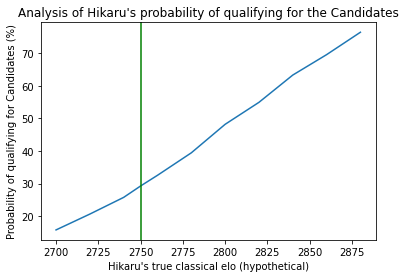

In [12]:
# Probability distribution of Hikaru candidates qualification


def prob_hikaru_qualifies(elo):
    orig_elo = name_to_rating[hikaru]
    name_to_rating[hikaru] = elo
    num_qualifies = 0
    for _ in range(MONTE_CARLO_ROUNDS):
        candidates_rows = sim_grand_prix()[:2]
        num_qualifies += int(any(row["Player"] == hikaru for _, row in candidates_rows.iterrows()))
    name_to_rating[hikaru] = orig_elo
    return num_qualifies / MONTE_CARLO_ROUNDS


hikaru_elo = np.sort(np.append(np.arange(2700, 2900, ELO_SPACING), name_to_rating[hikaru]))
candidates_prob = np.array([prob_hikaru_qualifies(elo) for elo in tqdm(hikaru_elo)])

plt.plot(hikaru_elo, candidates_prob * 100, label="Hikaru's Classical Elo (Hypothetical)")
plt.axvline(x=name_to_rating[hikaru], color="green")
plt.title("Analysis of Hikaru's probability of qualifying for the Candidates")
plt.xlabel("Hikaru's true classical elo (hypothetical)")
plt.ylabel("Probability of qualifying for Candidates (%)")
plt.savefig("hikaru_candidates_prob.png", facecolor="white")
plt.show()


In [13]:
# Average points per player

avg_final = sim_grand_prix().sort_values(by="Player").reset_index(drop=True)

for _ in range(MONTE_CARLO_ROUNDS - 1):
    final = sim_grand_prix().sort_values(by="Player").reset_index(drop=True)
    avg_final["Leg 1 Points"] += final["Leg 1 Points"]
    avg_final["Leg 2 Points"] += final["Leg 2 Points"]
    avg_final["Leg 3 Points"] += final["Leg 3 Points"]
    avg_final["Total Points"] += final["Total Points"]

avg_final["Leg 1 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 2 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 3 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Total Points"] /= MONTE_CARLO_ROUNDS

avg_final = avg_final.sort_values(by="Total Points", ascending=False).reset_index(drop=True)
avg_final.index = avg_final.index + 1

print(
    f"Average points by player for the simulated FIDE Grand Prix (assuming Hikaru's true elo is {name_to_rating[hikaru]}):"
)
avg_final


Average points by player for the simulated FIDE Grand Prix (assuming Hikaru's true elo is 2750):


,Player,Rating,Leg 1 Points,Leg 2 Points,Leg 3 Points,Total Points
1,Richard Rapport,2776.4,7.0,13.0,0.0000,20.0000
2,Hikaru Nakamura,2750.0,13.0,0.0,4.3713,17.3713
3,Levon Aronian,2785.0,10.0,0.0,6.4582,16.4582
4,Anish Giri,2772.8,0.0,7.0,6.4878,13.4878
5,Dmitry Andreikin,2729.4,0.0,10.0,3.2737,13.2737
6,Leinier Dominguez,2756.0,7.0,0.0,5.0245,12.0245
7,Maxime Vachier-Lagrave,2757.8,0.0,7.0,4.8830,11.8830
8,Wesley So,2778.0,4.0,0.0,6.1521,10.1521
9,Shakhriyar Mamedyarov,2771.2,0.0,4.0,5.9149,9.9149
10,Nikita Vitiugov,2724.2,0.0,4.0,4.1671,8.1671


In [14]:
# Probability of qualifying for the candidates, by player

prob_final = None

for _ in range(MONTE_CARLO_ROUNDS):
    sim = sim_grand_prix()
    if prob_final is None:
        prob_final = sim.copy(deep=True)
        prob_final["Candidates Qualification Probability (%)"] = 0
    sim.loc[:2, "num_qualified"] = 1
    sim.loc[2:, "num_qualified"] = 0
    new_prob_final = pd.merge(prob_final, sim, on=["Player", "Rating"], how="inner")
    new_prob_final["Candidates Qualification Probability (%)"] += new_prob_final["num_qualified"]
    prob_final = new_prob_final[
        ["Player", "Rating", "Candidates Qualification Probability (%)"]
    ].copy(deep=True)

prob_final["Candidates Qualification Probability (%)"] /= MONTE_CARLO_ROUNDS
prob_final["Candidates Qualification Probability (%)"] *= 100
prob_final = prob_final.sort_values(
    by="Candidates Qualification Probability (%)", ascending=False
).reset_index(drop=True)
prob_final.index = prob_final.index + 1

print(
    "Each player's probability of qualifying for the candidates "
    f"(assuming Hikaru's true elo is {name_to_rating[hikaru]}):"
)
prob_final


Each player's probability of qualifying for the candidates (assuming Hikaru's true elo is 2750):


,Player,Rating,Candidates Qualification Probability (%)
1,Richard Rapport,2776.4,60.44
2,Levon Aronian,2785.0,19.67
3,Hikaru Nakamura,2750.0,13.37
4,Dmitry Andreikin,2729.4,6.40
5,Maxime Vachier-Lagrave,2757.8,0.12
6,Vladimir Fedoseev,2700.8,0.00
7,Alexandr Predke,2687.6,0.00
8,Alexander Grischuk,2742.0,0.00
9,Pentala Harikrishna,2705.2,0.00
10,Etienne Bacrot,2637.8,0.00


In [15]:
# Average points per place

avg_final = sim_grand_prix()

for _ in range(MONTE_CARLO_ROUNDS - 1):
    final = sim_grand_prix()
    avg_final["Leg 1 Points"] += final["Leg 1 Points"]
    avg_final["Leg 2 Points"] += final["Leg 2 Points"]
    avg_final["Leg 3 Points"] += final["Leg 3 Points"]
    avg_final["Total Points"] += final["Total Points"]

avg_final["Leg 1 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 2 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Leg 3 Points"] /= MONTE_CARLO_ROUNDS
avg_final["Total Points"] /= MONTE_CARLO_ROUNDS

avg_final = avg_final.drop(["Player", "Rating"], axis=1)

print(f"Average points by standing position for the simulated FIDE Grand Prix:")
avg_final


Average points by standing position for the simulated FIDE Grand Prix:


,Leg 1 Points,Leg 2 Points,Leg 3 Points,Total Points
1,7.8845,8.6047,4.7150,21.2042
2,6.5237,6.6137,6.2597,19.3971
3,5.5348,2.8590,8.7918,17.1856
4,6.3514,2.4839,6.3828,15.2181
5,4.3423,3.7023,5.5742,13.6188
6,3.2223,4.3640,4.6031,12.1894
7,2.4182,4.1240,4.4415,10.9837
8,1.8912,4.2056,3.7704,9.8672
9,1.5697,3.6920,3.4266,8.6883
10,1.6007,3.2842,2.8412,7.7261


In [16]:
def gen_hikaru_qualify_func(can=True):
    """
    Returns a function to answer the question "can Hikaru qualify" if can=True,
    and "can Hikaru not qualify" if can=False
    """

    def hikaru_qualify_func(set_results=None, set_logic=None, print_solution=False):
        """
        set_results: a dict optionally mapping a player name to a fixed tier in leg 3 of the GP
        set_logic: a function optionally mapping the leg3_results dict to a list of constraints
        print_solution: print a feasible solution if found
        Returns a boolean representing whether Hikaru can qualify for the candidates given these constraints.
        """
        model = Solver("hikaru_qualification_model", Solver.CBC_MIXED_INTEGER_PROGRAMMING)

        final_points = defaultdict(int)

        leg1_points = defaultdict(int)
        for _, row in leg1_players_df.iterrows():
            leg1_points[row["Player"]] = row["Leg 1 Points"]
            final_points[row["Player"]] += row["Leg 1 Points"]

        leg2_points = defaultdict(int)
        for _, row in leg2_players_df.iterrows():
            leg2_points[row["Player"]] = row["Leg 2 Points"]
            final_points[row["Player"]] += row["Leg 2 Points"]

        leg3_results = defaultdict(int)
        leg3_points = defaultdict(int)
        for player in leg3_players:
            set_tier = set_results.get(player) if set_results is not None else None
            for tier in tiers:
                if set_tier is not None:
                    leg3_results[player, tier] = int(tier == set_tier)
                else:
                    leg3_results[player, tier] = model.BoolVar(f"{player}: {tier}")
                leg3_points[player] += leg3_results[player, tier] * tier_to_points[tier]
            model.Add(sum(leg3_results[player, tier] for tier in tiers) == 1)
            final_points[player] += leg3_points[player]

        # Enforce group constraints
        group_winning_tiers = ["winner", "runner-up", "semifinalist"]
        group_losing_tiers = ["group runner-up", "group 3rd place", "group last"]
        for group in leg3_groups_players:
            model.Add(
                sum(leg3_results[player, tier] for player in group for tier in group_winning_tiers)
                == 1
            )
            for tier in group_losing_tiers:
                model.Add(sum(leg3_results[player, tier] for player in group) == 1)

        # Enforce runner-up constraints
        for runner_up_candidate_groups in (leg3_groups_players[:2], leg3_groups_players[2:]):
            model.Add(
                sum(
                    leg3_results[player, "runner-up"]
                    for group in runner_up_candidate_groups
                    for player in group
                )
                == 1
            )

        # Enforce winner constraints
        model.Add(sum(leg3_results[player, "winner"] for player in leg3_players) == 1)

        # Enforce custom user-defined constraints
        if set_logic is not None:
            for constraint in set_logic(leg3_results):
                model.Add(constraint)

        # Ensure user defined constraints are logically consistent
        if model.Solve() == Solver.INFEASIBLE:
            raise ValueError(
                "Model is infeasible: set_results and set_logic are not logically consistent."
                f"\nset_results={set_results}"
            )

        # Indicator variables for players beating Hikaru
        beats_hikaru = dict()
        b = final_points[hikaru]
        b_min = leg1_points[hikaru] + leg2_points[hikaru]
        b_max = b_min + max_points
        for player in final_points:
            if player == hikaru:
                continue
            n_min = leg1_points[player] + leg2_points[player]
            n_max = n_min + max_points
            n = final_points[player]
            L = n_min - b_max
            U = n_max - b_min
            c = beats_hikaru[player] = model.BoolVar(f"{player} beats Hikaru")
            model.Add(n - b >= L * (1 - c))
            model.Add(n - b <= (U + 1) * c - 1)

        # Enforce that Hikaru qualifies for the candidates
        if can:
            model.Add(sum(beats_hikaru.values()) <= 1)
        else:
            model.Add(sum(beats_hikaru.values()) >= 3)

        feasible = model.Solve() != Solver.INFEASIBLE

        if feasible and print_solution:
            print("Feasible solution:")
            for key, var in leg3_results.items():
                if isinstance(var, int):
                    if var:
                        print(f"\t- {key[0]} is {key[1]}")
                elif var.solution_value():
                    print(f"\t- {var}")

        return feasible

    return hikaru_qualify_func


In [17]:
can_hikaru_qualify = gen_hikaru_qualify_func(can=True)
can_hikaru_not_qualify = gen_hikaru_qualify_func(can=False)


def gen_hikaru_qualify_string(set_results=None):
    can = can_hikaru_qualify(set_results=set_results)
    can_not = can_hikaru_not_qualify(set_results=set_results)
    if not can_not:
        return "Hikaru will definitely qualify"
    elif can:
        return "Hikaru might qualify"
    return "Hikaru cannot qualify"


In [18]:
for tier in tiers:
    print(f"If Hikaru is {tier} then: {gen_hikaru_qualify_string(set_results={hikaru: tier})}")


If Hikaru is winner then: Hikaru will definitely qualify
If Hikaru is runner-up then: Hikaru will definitely qualify
If Hikaru is semifinalist then: Hikaru will definitely qualify
If Hikaru is group runner-up then: Hikaru might qualify
If Hikaru is group 3rd place then: Hikaru might qualify
If Hikaru is group last then: Hikaru cannot qualify


In [19]:
def explore_paths(hikaru_tier):
    hikaru_tier_idx = tiers.index(hikaru_tier)
    num_above_in_group = max(hikaru_tier_idx + 4 - len(tiers), 0)
    num_below_in_group = 3 - num_above_in_group
    hikaru_group = leg3_groups_players[0]
    assert hikaru in hikaru_group
    leg3_other_players = set(leg3_players) - {hikaru}
    at_least_semifinals = tiers[:3]
    at_least_finals = tiers[:2]

    breaking_conditions = []

    for player in leg3_other_players:
        if player not in hikaru_group and not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in tiers[hikaru_tier_idx:]) == 1
            ],
        ):
            print(
                f"If Hikaru is {hikaru_tier} and {player} gets the same or worse tier, then: "
                "Hikaru cannot qualify (without relying on tiebreak criteria)."
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in tiers[hikaru_tier_idx:]
                )
                == 0
            )
        elif not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in tiers[hikaru_tier_idx + 1 :]) == 1
            ],
        ):
            print(
                f"If Hikaru is {hikaru_tier} and {player} gets a strictly worse tier, then: "
                "Hikaru cannot qualify."
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in tiers[hikaru_tier_idx + 1 :]
                )
                == 0
            )

    messages = []
    for player in leg3_other_players:
        if player not in hikaru_group and not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in tiers[: hikaru_tier_idx + 1]) == 1
            ],
        ):
            messages.append(
                (
                    0,
                    f"If Hikaru is {hikaru_tier} and {player} gets the same or better tier, then: "
                    "Hikaru cannot qualify (without relying on tiebreak criteria).",
                )
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in tiers[: hikaru_tier_idx + 1]
                )
                == 0
            )
        elif not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in tiers[:hikaru_tier_idx]) == 1
            ],
        ):
            messages.append(
                (
                    1,
                    f"If Hikaru is {hikaru_tier} and {player} gets a strictly better tier, then: "
                    "Hikaru cannot qualify.",
                )
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in tiers[:hikaru_tier_idx]
                )
                == 0
            )
        elif not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in at_least_semifinals) == 1
            ],
        ):
            messages.append(
                (
                    2,
                    f"If Hikaru is {hikaru_tier} and {player} reaches the semifinals, then: "
                    "Hikaru cannot qualify.",
                )
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in at_least_semifinals
                )
                == 0
            )
        elif not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                sum(leg3_results[player, tier] for tier in at_least_finals) == 1
            ],
        ):
            messages.append(
                (
                    3,
                    f"If Hikaru is {hikaru_tier} and {player} reaches the finals, then: "
                    "Hikaru cannot qualify.",
                )
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: sum(
                    leg3_results[player, tier] for tier in at_least_finals
                )
                == 0
            )
        elif not can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [leg3_results[player, "winner"] == 1],
        ):
            messages.append(
                (
                    4,
                    f"If Hikaru is {hikaru_tier} and {player} wins leg 3 of the GP, then: "
                    "Hikaru cannot qualify.",
                )
            )
            breaking_conditions.append(
                lambda leg3_results, player=player: leg3_results[player, "winner"] == 0
            )
    for _, message in sorted(messages):
        print(message)

    if not can_hikaru_not_qualify(
        set_results={hikaru: hikaru_tier},
        set_logic=lambda leg3_results: [
            condition_func(leg3_results) for condition_func in breaking_conditions
        ],
        print_solution=True,
    ):
        print(
            f"\nIf Hikaru is {hikaru_tier} and none of the above conditions hold, then Hikaru will qualify."
        )
        print("Consider the following example.")
        can_hikaru_qualify(
            set_results={hikaru: hikaru_tier},
            set_logic=lambda leg3_results: [
                condition_func(leg3_results) for condition_func in breaking_conditions
            ],
            print_solution=True,
        )


In [20]:
print(
    "The first ambigious result is if Hikaru is group runner-up.\n"
    "In this case we can reason about the results of other players "
    "to explore Hikaru's possible paths to qualification.\n"
)
print(
    "NOTE: The following statements assume unfavorable tiebreak criteria for Hikaru (FIDE rly would).\n"
    "This is a conservative assumption, as Hikaru might happen to win on tiebreak criteria in some cases.\n"
    "In some cases, it is impossible for Hikaru to reach even tiebreak consideration for the top 2 spots.\n"
)

explore_paths(hikaru_tier="group runner-up")


The first ambigious result is if Hikaru is group runner-up.
In this case we can reason about the results of other players to explore Hikaru's possible paths to qualification.

NOTE: The following statements assume unfavorable tiebreak criteria for Hikaru (FIDE rly would).
This is a conservative assumption, as Hikaru might happen to win on tiebreak criteria in some cases.
In some cases, it is impossible for Hikaru to reach even tiebreak consideration for the top 2 spots.

If Hikaru is group runner-up and Grigoriy Oparin gets a strictly worse tier, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Dmitry Andreikin gets a strictly better tier, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Levon Aronian gets a strictly better tier, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Anish Giri reaches the finals, then: Hikaru cannot qualify.
If Hikaru is group runner-up and Leinier Dominguez reaches the finals, then: Hikaru cannot qualify.
If Hikaru is

In [21]:
print(
    "The second ambigious result is if Hikaru is 3rd in his group.\n"
    "In this case we can reason about the results of other players "
    "to explore Hikaru's possible paths to qualification.\n"
)

explore_paths(hikaru_tier="group 3rd place")


The second ambigious result is if Hikaru is 3rd in his group.
In this case we can reason about the results of other players to explore Hikaru's possible paths to qualification.

If Hikaru is group 3rd place and Grigoriy Oparin gets a strictly worse tier, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Dmitry Andreikin reaches the semifinals, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Levon Aronian reaches the semifinals, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Anish Giri reaches the finals, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Leinier Dominguez reaches the finals, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Maxime Vachier-Lagrave reaches the finals, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Alexandr Predke wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is group 3rd place and Amin Tabatabaei wins leg 3 of the GP, then: Hikaru cannot qualify.
If Hikaru is gr